<IPython.core.display.Javascript object>


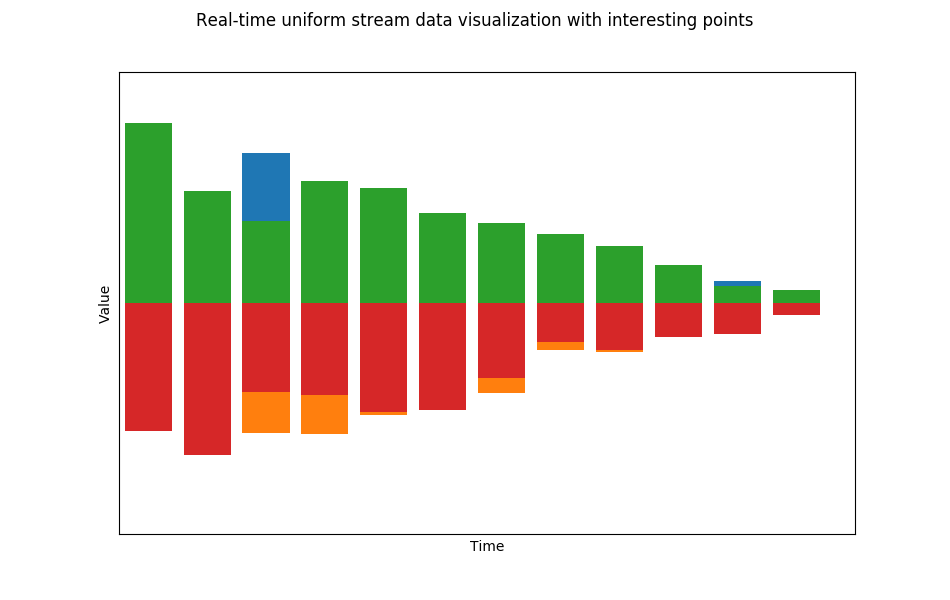

KeyboardInterrupt: 

In [56]:
#Task C 3.1
from time import sleep
import pprint
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import ast

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'Producer1'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['127.0.0.1:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,35) 
        ax.set_yticks([0,5,10,15,20,25,30])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    data = {}
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = message.value.decode('utf-8')
            dic = ast.literal_eval(data)
#             print(data)
            #print(dic['air_temperature_celcius'])
            temp = dic['air_temperature_celcius']
            time = dt.datetime.now().strftime("%X")
            x.append(time) 
            y.append(temp)
            # print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                ax.set_ylim(0,35) 
                ax.set_yticks([0,5,10,15,20,25,30])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

In [52]:
#Task C 3b i
import pymongo
import csv
import pprint
from pymongo import MongoClient

client = MongoClient () 
db = client.fit5148_assignment_db
def find():
    dic=[]
    Question_f = db.hotspot_climate.aggregate([{"$project": {"Total number of fire":{"$size":"$hotspot"}, "date":1, "_id":0}},{"$sort": {"Total number of fire":-1}},{"$limit": 10}])
    for a in Question_f:
        dic.append(a)
    
    return dic   

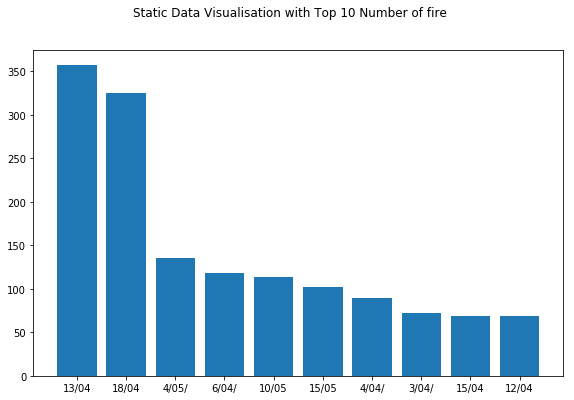

In [65]:
import matplotlib.pyplot as plt
import numpy as np

width = 9.5
height = 6
fig = plt.figure(figsize=(width,height)) # create new figure
ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
fig.suptitle('Static Data Visualisation with Top 10 Number of fire')

ylabels = []
xdata = []
dataset = find()
for data in dataset:
    xdata.append(data['Total number of fire'])
    date = data['date']
    ylabels.append(date[:5])


plt.bar(range(len(xdata)), xdata, tick_label=ylabels)

plt.show()


In [ ]:
#Task C3 bii
import pymongo
import csv
import pprint
from pymongo import MongoClient
import gmplot
import webbrowser

hotspot = db.hotspot_climate


# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city

print(hotspot.find())
List = []
temp =''
confidence=''
air=''
humid=''
for row in hotspot.find():
    if row['hotspot'] != "":
        for data in row['hotspot']:
            List.append((float(data['latitude']), float(data['longitude'])))
            temp = str(data['surface_temperature_celcius'])
            confidence = str(data['confidence'])
            air =str(row['climate']['air_temperature_celcius'])
            humid = str(row['climate']['relative_humidity'])     
    gmap.marker(data['latitude'], data['longitude'], title = str('surface_temperature_celcius: '+ temp + ', air temperature: '+ air + ', Relative humidity' + humid + ', confidence: ' + confidence))
                                                    
                        
lats,lons = zip(*List)
gmap.scatter(lats, lons, '#FF4500', size=20, marker=True)

           
        
        
gmap.draw("hotspot.html")
webbrowser.open_new("hotspot.html")
